The Avila data set has been extracted from 800 images of the the "Avila Bible", a giant Latin copy of the whole Bible produced during the XII century between Italy and Spain.  
The palaeographic analysis of the  manuscript has  individuated the presence of 12 copyists. The pages written by each copyist are not equally numerous. 
Each pattern contains 10 features and corresponds to a group of 4 consecutive rows.

The prediction task consists in associating each pattern to one of the 12 copyists (labeled as: A, B, C, D, E, F, G, H, I, W, X, Y).
The data have has been normalized, by using the Z-normalization method, and divided in two data sets: a training set containing 10430 samples, and a test set  containing the 10437 samples.

Class distribution (training set)
A: 4286
B: 5  
C: 103 
D: 352 
E: 1095 
F: 1961 
G: 446 
H: 519
I: 831
W: 44
X: 522 
Y: 266

ATTRIBUTE DESCRIPTION

ID      Name    
F1       intercolumnar distance 
F2       upper margin 
F3       lower margin 
F4       exploitation 
F5       row number 
F6       modular ratio 
F7       interlinear spacing 
F8       weight 
F9       peak number 
F10     modular ratio/ interlinear spacing
Class: A, B, C, D, E, F, G, H, I, W, X, Y


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import pickle
from sklearn.model_selection import validation_curve, cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
database = pd.read_csv('avila-tr.txt', sep=",")

In [3]:
database_test = pd.read_csv('avila-ts.txt', header = None, sep=",")

In [4]:
database_test.columns = ["intercolumnar distance", "upper margin", "lower margin", "exploitation", "row number", "modular ratio",
                        "interlinear spacing", "weight", "peak number", "modular ratio/ interlinear spacing", "class"]

In [5]:
database = database.rename(columns={"intercolumnar distance": "F1", "upper margin": "F2", "lower margin": "F3", "exploitation": "F4",
                        "row number": "F5", "modular ratio": "F6", "interlinear spacing": "F7", "weight": "F8", 
                        "peak number": "F9", "modular ratio/ interlinear spacing": "F10", " class": "class"})
database_test = database_test.rename(columns={"intercolumnar distance": "F1", "upper margin": "F2", "lower margin": "F3", "exploitation": "F4",
                        "row number": "F5", "modular ratio": "F6", "interlinear spacing": "F7", "weight": "F8", 
                        "peak number": "F9", "modular ratio/ interlinear spacing": "F10"})

In [6]:
database.columns, database_test.columns

(Index(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'class'], dtype='object'),
 Index(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'class'], dtype='object'))

In [7]:
database.dtypes, database_test.dtypes

(F1       float64
 F2       float64
 F3       float64
 F4       float64
 F5       float64
 F6       float64
 F7       float64
 F8       float64
 F9       float64
 F10      float64
 class     object
 dtype: object,
 F1       float64
 F2       float64
 F3       float64
 F4       float64
 F5       float64
 F6       float64
 F7       float64
 F8       float64
 F9       float64
 F10      float64
 class     object
 dtype: object)

#### On constate que les variables sont premièrement de même type entre train et test et surtout que l'ensemble des variables sont des float à l'exception d'une : 'class' notre variable de prédiction. On peut donc annoncer dès lors que notre problème sera celui d'une classification.

In [8]:
target = 'class'

In [9]:
database.columns

Index(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'class'], dtype='object')

#### On split le dataset en détachant la variable de prédiction afin de bien différencier X et Y

In [10]:
y = database[target]
x = database.drop(target, axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 0)

# Preprocessing

#### Test valeurs NA

In [11]:
database.isnull().values.any()

False

#### Il n'y a donc aucune valeur NA : il n'y a pas de nettoyage à faire à ce niveau

#### Normalisation des valeurs

In [12]:
scaler = preprocessing.StandardScaler().fit(x_train)

In [13]:
scaler.mean_, scaler.scale_

(array([ 0.00169849,  0.03980698,  0.00153056, -0.00548555,  0.00890724,
         0.02280871,  0.00851373,  0.00462168,  0.01596709,  0.0057365 ]),
 array([0.99804695, 4.46715465, 1.15367818, 1.0197531 , 0.98830433,
        1.16779084, 1.3728213 , 0.99328777, 1.11492302, 1.00168716]))

In [14]:
x_train = scaler.transform(x_train)

In [15]:
x_train.mean(axis = 0), x_train.std(axis = 0)

(array([ 1.27174614e-17, -2.27097525e-18,  5.45034060e-18, -2.27097525e-17,
         1.27174614e-17,  1.27174614e-17,  9.08390099e-18,  2.72517030e-18,
        -8.62970594e-18, -1.77136069e-17]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

#### On a bien normalisé nos valeurs afin de nous assurer que les différences d'échelle entre les variables n'influent pas sur notre résultat

# Train modèles

In [16]:
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

C:\Users\quent\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [17]:
@ignore_warnings(category=ConvergenceWarning)
def test_model(model, X, y):

  accuracy = cross_val_score(model, X, y, scoring='accuracy', verbose=1)
  avg_accuracy = accuracy.mean()

  return avg_accuracy

In [18]:
def analyse_with_plot(x, train_score, val_score, x_label, title, figsize=(12, 6)):

  plt.figure(figsize=figsize)
  plt.plot(x, train_score, linestyle='dashed', marker='o', label='train score')
  plt.plot(x, val_score, linestyle='dashed', marker='o', label='validation score')
  plt.xlabel(x_label)
  plt.ylabel('Précision')
  plt.title(title)
  plt.legend()
  plt.grid(b=True, which='major', color='#bdc3c7', linestyle='--')
  plt.show()

In [19]:
def analyse_with_bar(x, y1, y2, x_label, title, figsize=(12, 6)):

  x_values = np.arange(len(x)) 
  barWidth = 0.15

  plt.figure(figsize=(12,6))
  plt.bar(x_values, y1, width=barWidth, label='train score')
  plt.bar(x_values - barWidth, y2, width=barWidth, label='validation score')
  plt.xlabel(x_label)
  plt.ylabel('Précision')
  plt.xticks([r for r in range(len(y1))], x)
  plt.title(title)
  plt.legend()
  plt.show()

#### Logistic regression

##### Test modèle sans hyper-paramètres

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
lr_model = LogisticRegression()

In [22]:
accuracy_lr_model = test_model(lr_model, x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished


In [23]:
accuracy_lr_model

0.5620046901938995

##### Test sur les hyper-paramètres : "C", "penalty", "solver", "max_iter" 

In [24]:
C_range = np.logspace(-3, 2, 6)
solver_range = ['newton-cg', 'sag', 'saga', 'lbfgs']
max_iter_range = np.arange(1, 1000, 100)

###### On commence par affecter un large espace de recherche pour la valeur optimale de "C" puis on visualise, via la courbe de validation, l'intervalle préferentiel afin d'effectuer notre sélecteur d'hyperparamètres

In [25]:
lr_C_train_score, lr_C_test_score = validation_curve(lr_model, x_train, y_train,
                       'C', C_range,                       
                       verbose=1)

lr_C_train_score_mean = np.mean(lr_C_train_score, axis=1)
lr_C_train_score_std = np.std(lr_C_train_score, axis=1)

lr_C_test_score_mean = np.mean(lr_C_test_score, axis=1)
lr_C_test_score_std = np.std(lr_C_test_score, axis=1)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass param_name=C, param_range=[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762:

C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

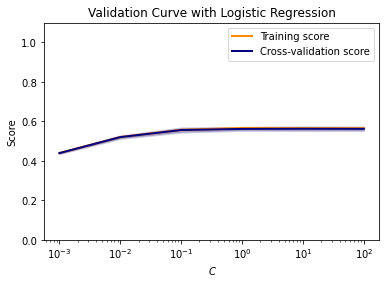

In [26]:
plt.title("Validation Curve with Logistic Regression")
plt.xlabel(r"$\ C$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(C_range, lr_C_train_score_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(C_range, lr_C_train_score_mean - lr_C_train_score_std,
                 lr_C_train_score_mean + lr_C_train_score_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(C_range, lr_C_test_score_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(C_range, lr_C_test_score_mean - lr_C_test_score_std,
                 lr_C_test_score_mean + lr_C_test_score_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

###### On affine l'intervalle tel que:

In [27]:
C_range = np.logspace(-1, 2, 6)

###### On commence par affecter un large espace de recherche pour la valeur optimale de "solver" puis on visualise, via la courbe de validation, l'intervalle préferentiel afin d'effectuer notre sélecteur d'hyperparamètres

In [28]:
lr_max_iter_train_score, lr_max_iter_test_score = validation_curve(lr_model, x_train, y_train,
                       'max_iter', max_iter_range,                       
                       verbose=1)

lr_max_iter_train_score_mean = np.mean(lr_max_iter_train_score, axis=1)
lr_max_iter_train_score_std = np.std(lr_max_iter_train_score, axis=1)

lr_max_iter_test_score_mean = np.mean(lr_max_iter_test_score, axis=1)
lr_max_iter_test_score_std = np.std(lr_max_iter_test_score, axis=1)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass param_name=max_iter, param_range=[  1 101 201 301 401 501 601 701 801 901] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py

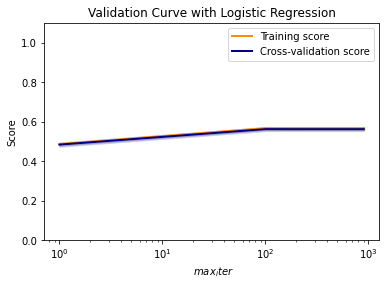

In [29]:
plt.title("Validation Curve with Logistic Regression")
plt.xlabel(r"$\ max_iter$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(max_iter_range, lr_max_iter_train_score_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(max_iter_range, lr_max_iter_train_score_mean - lr_max_iter_train_score_std,
                 lr_max_iter_train_score_mean + lr_max_iter_train_score_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(max_iter_range, lr_max_iter_test_score_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(max_iter_range, lr_max_iter_test_score_mean - lr_max_iter_test_score_std,
                 lr_max_iter_test_score_mean + lr_max_iter_test_score_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

###### On affine l'intervalle tel que:

In [30]:
max_iter_range = np.arange(100, 1000, 10)

##### On cherche maintenant les hyperparamètres idéaux

In [31]:
param_distributions = {'C': C_range,                       
                       'solver' : solver_range,
                       'max_iter': max_iter_range}

search = RandomizedSearchCV(estimator=LogisticRegression(random_state=0),
                            n_iter=5,
                            param_distributions=param_distributions,
                            random_state=0)
search.fit(x_train, y_train)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\quent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (stat

RandomizedSearchCV(estimator=LogisticRegression(random_state=0), n_iter=5,
                   param_distributions={'C': array([  0.1       ,   0.39810717,   1.58489319,   6.30957344,
        25.11886432, 100.        ]),
                                        'max_iter': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220,
       230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350,
       360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480,
       490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610,
       620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740,
       750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870,
       880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990]),
                                        'solver': ['newton-cg', 'sag', 'saga',
                                                   'lbfgs']},
                   random_state=0)

In [32]:
search.best_params_, search.score(x_train, y_train)

({'solver': 'sag', 'max_iter': 630, 'C': 25.118864315095795},
 0.5655842495525442)

In [33]:
if (search.score(x_train, y_train) > accuracy_lr_model):
    lr_model = search

#### KNN

##### Test modèle sans hyper-paramètres

In [34]:
from sklearn.neighbors import KNeighborsClassifier

In [35]:
knn_model = KNeighborsClassifier().fit(x_train, y_train)

In [36]:
accuracy_knn_model = test_model(knn_model, x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


In [37]:
accuracy_knn_model

0.6807736368613287

##### Test sur les hyper-paramètres : "n_neighbors", "weights", "algorithm", "leaf_size", "p"

In [38]:
n_neighbors_range = np.arange(1 , 100, 5)
weights_range = ['uniform', 'distance']
algorithm_range = ['ball_tree', 'kid_tree', 'brute']
leaf_size_range = np.logspace(0, 2, 6)
p_range = np.arange(1, 10, 1)

###### On commence par affecter un large espace de recherche pour la valeur optimale de "n_neighbors" puis on visualise, via la courbe de validation, l'intervalle préferentiel afin d'effectuer notre sélecteur d'hyperparamètres

In [39]:
knn_n_neighbors_train_score, knn_n_neighbors_test_score = validation_curve(knn_model, x_train, y_train,
                       'n_neighbors', n_neighbors_range,                       
                       verbose=1)

knn_n_neighbors_train_score_mean = np.mean(knn_n_neighbors_train_score, axis=1)
knn_n_neighbors_train_score_std = np.std(knn_n_neighbors_train_score, axis=1)

knn_n_neighbors_test_score_mean = np.mean(knn_n_neighbors_test_score, axis=1)
knn_n_neighbors_test_score_std = np.std(knn_n_neighbors_test_score, axis=1)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass param_name=n_neighbors, param_range=[ 1  6 11 16 21 26 31 36 41 46 51 56 61 66 71 76 81 86 91 96] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.3min finished


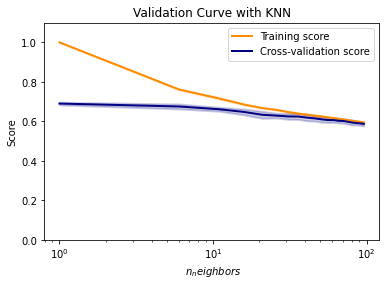

In [40]:
plt.title("Validation Curve with KNN")
plt.xlabel(r"$\ n_neighbors$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(n_neighbors_range, knn_n_neighbors_train_score_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(n_neighbors_range, knn_n_neighbors_train_score_mean - knn_n_neighbors_train_score_std,
                 knn_n_neighbors_train_score_mean + knn_n_neighbors_train_score_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(n_neighbors_range, knn_n_neighbors_test_score_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(n_neighbors_range, knn_n_neighbors_test_score_mean - knn_n_neighbors_test_score_std,
                 knn_n_neighbors_test_score_mean + knn_n_neighbors_test_score_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

###### On affine l'intervalle tel que:

In [41]:
n_neighbors_range = np.arange(5, 75, 5)

###### On commence par affecter un large espace de recherche pour la valeur optimale de "leaf_size" puis on visualise, via la courbe de validation, l'intervalle préferentiel afin d'effectuer notre sélecteur d'hyperparamètres

In [42]:
knn_leaf_size_train_score, knn_leaf_size_test_score = validation_curve(knn_model, x_train, y_train,
                       'leaf_size', leaf_size_range,                       
                       verbose=1)

knn_leaf_size_train_score_mean = np.mean(knn_leaf_size_train_score, axis=1)
knn_leaf_size_train_score_std = np.std(knn_leaf_size_train_score, axis=1)

knn_leaf_size_test_score_mean = np.mean(knn_leaf_size_test_score, axis=1)
knn_leaf_size_test_score_std = np.std(knn_leaf_size_test_score, axis=1)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass param_name=leaf_size, param_range=[  1.           2.51188643   6.30957344  15.84893192  39.81071706
 100.        ] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   27.6s finished


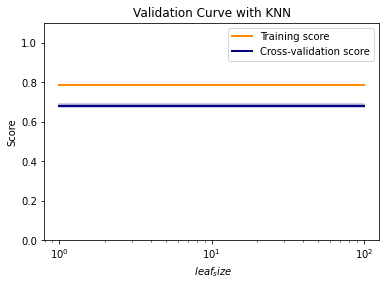

In [43]:
plt.title("Validation Curve with KNN")
plt.xlabel(r"$\ leaf_size$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(leaf_size_range, knn_leaf_size_train_score_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(leaf_size_range, knn_leaf_size_train_score_mean - knn_leaf_size_train_score_std,
                 knn_leaf_size_train_score_mean + knn_leaf_size_train_score_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(leaf_size_range, knn_leaf_size_test_score_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(leaf_size_range, knn_leaf_size_test_score_mean - knn_leaf_size_test_score_std,
                 knn_leaf_size_test_score_mean + knn_leaf_size_test_score_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

###### On arrive à la conclusion que leaf_size n'est pas un hyperparamètre intéréssant à manipuler !

###### On commence par affecter un large espace de recherche pour la valeur optimale de "p" puis on visualise, via la courbe de validation, l'intervalle préferentiel afin d'effectuer notre sélecteur d'hyperparamètres

In [44]:
knn_p_train_score, knn_p_test_score = validation_curve(knn_model, x_train, y_train,
                       'p', p_range,                       
                       verbose=1)

knn_p_train_score_mean = np.mean(knn_p_train_score, axis=1)
knn_p_train_score_std = np.std(knn_p_train_score, axis=1)

knn_p_test_score_mean = np.mean(knn_p_test_score, axis=1)
knn_p_test_score_std = np.std(knn_p_test_score, axis=1)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass param_name=p, param_range=[1 2 3 4 5 6 7 8 9] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.2min finished


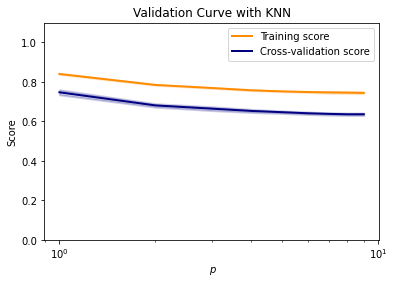

In [45]:
plt.title("Validation Curve with KNN")
plt.xlabel(r"$\ p$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(p_range, knn_p_train_score_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(p_range, knn_p_train_score_mean - knn_p_train_score_std,
                 knn_p_train_score_mean + knn_p_train_score_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(p_range, knn_p_test_score_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(p_range, knn_p_test_score_mean - knn_p_test_score_std,
                 knn_p_test_score_mean + knn_p_test_score_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

###### On arrive à la conclusion que leaf_size n'est pas un hyperparamètre intéréssant à manipuler !

In [46]:
p_range = np.arange(1, 4, 1)

##### On cherche maintenant les hyperparamètres idéaux

In [47]:
param_distributions = {'n_neighbors': n_neighbors_range,                       
                       'weights' : weights_range,
                       'algorithm': algorithm_range,
                       'p' : p_range}

search = RandomizedSearchCV(estimator=KNeighborsClassifier(),
                            n_iter=5,
                            param_distributions=param_distributions,
                            random_state=0)
search.fit(x_train, y_train)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\quent\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\quent\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\quent\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 350, in _fit
    self._check_algorithm_metric()
  File "C:\Users\quent\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 310, in _check_algorithm_metric
    raise ValueError("unrecognized algorithm: '%s'" % self.algorithm)
ValueError: unrecognized algorithm: 'kid_tree'

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\quent\anac

RandomizedSearchCV(estimator=KNeighborsClassifier(), n_iter=5,
                   param_distributions={'algorithm': ['ball_tree', 'kid_tree',
                                                      'brute'],
                                        'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]),
                                        'p': array([1, 2, 3]),
                                        'weights': ['uniform', 'distance']},
                   random_state=0)

In [48]:
search.best_params_, search.score(x_train, y_train)

({'weights': 'uniform', 'p': 2, 'n_neighbors': 5, 'algorithm': 'brute'},
 0.7991562260291486)

In [49]:
if (search.score(x_train, y_train) > accuracy_knn_model):
    knn_model = search

#### KNN

##### Test modèle sans hyper-paramètres

In [50]:
from sklearn.neighbors import KNeighborsClassifier

In [51]:
knn_model = KNeighborsClassifier()

In [52]:
accuracy_knn_model = test_model(knn_model, x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


In [53]:
accuracy_knn_model

0.6807736368613287

##### Test sur les hyper-paramètres : "n_neighbors", "weights", "algorithm", "leaf_size", "p"

In [54]:
n_neighbors_range = np.arange(1 , 100, 5)
weights_range = ['uniform', 'distance']
algorithm_range = ['ball_tree', 'kid_tree', 'brute']
leaf_size_range = np.logspace(0, 2, 6)
p_range = np.arange(1, 10, 1)

###### On commence par affecter un large espace de recherche pour la valeur optimale de "n_neighbors" puis on visualise, via la courbe de validation, l'intervalle préferentiel afin d'effectuer notre sélecteur d'hyperparamètres

In [55]:
knn_n_neighbors_train_score, knn_n_neighbors_test_score = validation_curve(knn_model, x_train, y_train,
                       'n_neighbors', n_neighbors_range,                       
                       verbose=1)

knn_n_neighbors_train_score_mean = np.mean(knn_n_neighbors_train_score, axis=1)
knn_n_neighbors_train_score_std = np.std(knn_n_neighbors_train_score, axis=1)

knn_n_neighbors_test_score_mean = np.mean(knn_n_neighbors_test_score, axis=1)
knn_n_neighbors_test_score_std = np.std(knn_n_neighbors_test_score, axis=1)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass param_name=n_neighbors, param_range=[ 1  6 11 16 21 26 31 36 41 46 51 56 61 66 71 76 81 86 91 96] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.3min finished


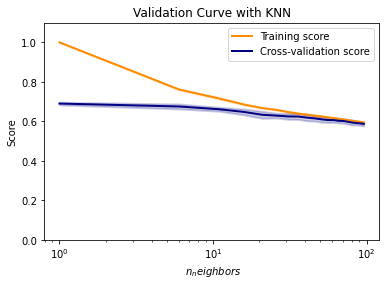

In [56]:
plt.title("Validation Curve with KNN")
plt.xlabel(r"$\ n_neighbors$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(n_neighbors_range, knn_n_neighbors_train_score_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(n_neighbors_range, knn_n_neighbors_train_score_mean - knn_n_neighbors_train_score_std,
                 knn_n_neighbors_train_score_mean + knn_n_neighbors_train_score_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(n_neighbors_range, knn_n_neighbors_test_score_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(n_neighbors_range, knn_n_neighbors_test_score_mean - knn_n_neighbors_test_score_std,
                 knn_n_neighbors_test_score_mean + knn_n_neighbors_test_score_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

###### On affine l'intervalle tel que:

In [57]:
n_neighbors_range = np.arange(5, 75, 5)

###### On commence par affecter un large espace de recherche pour la valeur optimale de "leaf_size" puis on visualise, via la courbe de validation, l'intervalle préferentiel afin d'effectuer notre sélecteur d'hyperparamètres

In [58]:
knn_leaf_size_train_score, knn_leaf_size_test_score = validation_curve(knn_model, x_train, y_train,
                       'leaf_size', leaf_size_range,                       
                       verbose=1)

knn_leaf_size_train_score_mean = np.mean(knn_leaf_size_train_score, axis=1)
knn_leaf_size_train_score_std = np.std(knn_leaf_size_train_score, axis=1)

knn_leaf_size_test_score_mean = np.mean(knn_leaf_size_test_score, axis=1)
knn_leaf_size_test_score_std = np.std(knn_leaf_size_test_score, axis=1)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass param_name=leaf_size, param_range=[  1.           2.51188643   6.30957344  15.84893192  39.81071706
 100.        ] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   27.5s finished


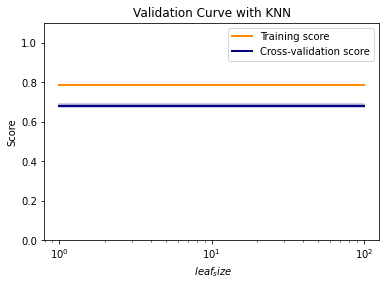

In [59]:
plt.title("Validation Curve with KNN")
plt.xlabel(r"$\ leaf_size$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(leaf_size_range, knn_leaf_size_train_score_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(leaf_size_range, knn_leaf_size_train_score_mean - knn_leaf_size_train_score_std,
                 knn_leaf_size_train_score_mean + knn_leaf_size_train_score_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(leaf_size_range, knn_leaf_size_test_score_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(leaf_size_range, knn_leaf_size_test_score_mean - knn_leaf_size_test_score_std,
                 knn_leaf_size_test_score_mean + knn_leaf_size_test_score_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

###### On affine l'intervalle tel que:

###### On commence par affecter un large espace de recherche pour la valeur optimale de "p" puis on visualise, via la courbe de validation, l'intervalle préferentiel afin d'effectuer notre sélecteur d'hyperparamètres

In [60]:
knn_p_train_score, knn_p_test_score = validation_curve(knn_model, x_train, y_train,
                       'p', p_range,                       
                       verbose=1)

knn_p_train_score_mean = np.mean(knn_p_train_score, axis=1)
knn_p_train_score_std = np.std(knn_p_train_score, axis=1)

knn_p_test_score_mean = np.mean(knn_p_test_score, axis=1)
knn_p_test_score_std = np.std(knn_p_test_score, axis=1)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass param_name=p, param_range=[1 2 3 4 5 6 7 8 9] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.2min finished


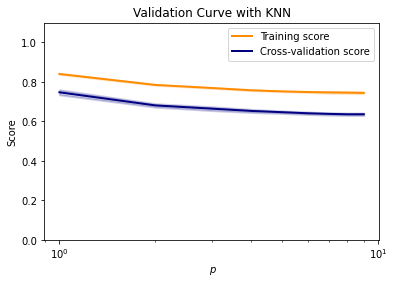

In [61]:
plt.title("Validation Curve with KNN")
plt.xlabel(r"$\ p$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(p_range, knn_p_train_score_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(p_range, knn_p_train_score_mean - knn_p_train_score_std,
                 knn_p_train_score_mean + knn_p_train_score_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(p_range, knn_p_test_score_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(p_range, knn_p_test_score_mean - knn_p_test_score_std,
                 knn_p_test_score_mean + knn_p_test_score_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

###### On arrive à la conclusion que leaf_size n'est pas un hyperparamètre intéréssant à manipuler !

In [62]:
p_range = np.arange(1, 4, 1)

##### On cherche maintenant les hyperparamètres idéaux

In [63]:
param_distributions = {'n_neighbors': n_neighbors_range,                       
                       'weights' : weights_range,
                       'algorithm': algorithm_range,
                       'p' : p_range}

search = RandomizedSearchCV(estimator=KNeighborsClassifier(),
                            n_iter=5,
                            param_distributions=param_distributions,
                            random_state=0)
search.fit(x_train, y_train)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\quent\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\quent\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 1157, in fit
    return self._fit(X)
  File "C:\Users\quent\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 350, in _fit
    self._check_algorithm_metric()
  File "C:\Users\quent\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 310, in _check_algorithm_metric
    raise ValueError("unrecognized algorithm: '%s'" % self.algorithm)
ValueError: unrecognized algorithm: 'kid_tree'

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\quent\anac

RandomizedSearchCV(estimator=KNeighborsClassifier(), n_iter=5,
                   param_distributions={'algorithm': ['ball_tree', 'kid_tree',
                                                      'brute'],
                                        'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]),
                                        'p': array([1, 2, 3]),
                                        'weights': ['uniform', 'distance']},
                   random_state=0)

In [64]:
search.best_params_, search.score(x_train, y_train)

({'weights': 'uniform', 'p': 2, 'n_neighbors': 5, 'algorithm': 'brute'},
 0.7991562260291486)

In [65]:
if (search.score(x_train, y_train) > accuracy_knn_model):
    knn_model = search

#### Random Forest

##### Test modèle sans hyper-paramètres

In [82]:
from sklearn.ensemble import RandomForestClassifier

In [84]:
rfc_model = RandomForestClassifier()

In [89]:
accuracy_rfc_model = test_model(rfc_model, x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.7s finished


In [90]:
accuracy_rfc_model

0.9636925063121511

##### Test sur les hyper-paramètres : "n_estimators", "criterion", "max_depth", "min_samples_leaf", "max_features"

In [122]:
n_estimators_range = np.arange(100, 1100, 200)
criterion_range = ['gini', 'entropy']
max_depth_range = np.arange(1, 100, 5)
min_samples_leaf_range = np.arange(1, 10, 1)
max_features_range = ['auto', 'sqrt', 'log2']

###### On commence par affecter un large espace de recherche pour la valeur optimale de "n_estimators" puis on visualise, via la courbe de validation, l'intervalle préferentiel afin d'effectuer notre sélecteur d'hyperparamètres

In [103]:
rfc_n_estimators_train_score, rfc_n_estimators_test_score = validation_curve(rfc_model, x_train, y_train,
                       'n_estimators', n_estimators_range, verbose=1)

rfc_n_estimators_train_score_mean = np.mean(rfc_n_estimators_train_score, axis=1)
rfc_n_estimators_train_score_std = np.std(rfc_n_estimators_train_score, axis=1)

rfc_n_estimators_test_score_mean = np.mean(rfc_n_estimators_test_score, axis=1)
rfc_n_estimators_test_score_std = np.std(rfc_n_estimators_test_score, axis=1)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass param_name=n_estimators, param_range=[100 300 500 700 900] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.2min finished


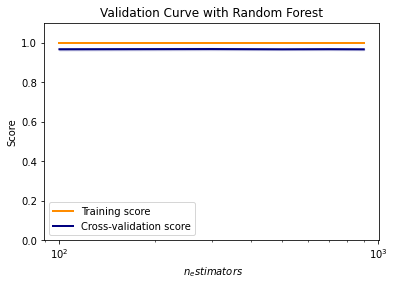

In [104]:
plt.title("Validation Curve with Random Forest")
plt.xlabel(r"$\ n_estimators$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(n_estimators_range, rfc_n_estimators_train_score_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(n_estimators_range, rfc_n_estimators_train_score_mean - rfc_n_estimators_train_score_std,
                 rfc_n_estimators_train_score_mean + rfc_n_estimators_train_score_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(n_estimators_range, rfc_n_estimators_test_score_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(n_estimators_range, rfc_n_estimators_test_score_mean - rfc_n_estimators_test_score_std,
                 rfc_n_estimators_test_score_mean + rfc_n_estimators_test_score_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

###### On arrive à la conclusion que n_estimators n'est pas un hyperparamètre intéréssant à manipuler !

###### On commence par affecter un large espace de recherche pour la valeur optimale de "max_depth" puis on visualise, via la courbe de validation, l'intervalle préferentiel afin d'effectuer notre sélecteur d'hyperparamètres

In [105]:
rfc_max_depth_train_score, rfc_max_depth_test_score = validation_curve(rfc_model, x_train, y_train,
                       'max_depth', max_depth_range, verbose=1)

rfc_max_depth_train_score_mean = np.mean(rfc_max_depth_train_score, axis=1)
rfc_max_depth_train_score_std = np.std(rfc_max_depth_train_score, axis=1)

rfc_max_depth_test_score_mean = np.mean(rfc_max_depth_test_score, axis=1)
rfc_max_depth_test_score_std = np.std(rfc_max_depth_test_score, axis=1)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass param_name=max_depth, param_range=[ 1  6 11 16 21 26 31 36 41 46 51 56 61 66 71 76 81 86 91 96] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.6min finished


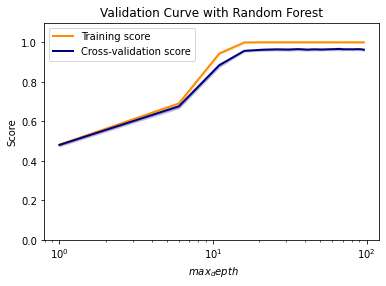

In [106]:
plt.title("Validation Curve with Random Forest")
plt.xlabel(r"$\ max_depth$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(max_depth_range, rfc_max_depth_train_score_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(max_depth_range, rfc_max_depth_train_score_mean - rfc_max_depth_train_score_std,
                 rfc_max_depth_train_score_mean + rfc_max_depth_train_score_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(max_depth_range, rfc_max_depth_test_score_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(max_depth_range, rfc_max_depth_test_score_mean - rfc_max_depth_test_score_std,
                 rfc_max_depth_test_score_mean + rfc_max_depth_test_score_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

###### On affine l'intervalle tel que:

In [107]:
max_depth_range = np.arange(25, 75, 5)

###### On commence par affecter un large espace de recherche pour la valeur optimale de "min_samples_split" puis on visualise, via la courbe de validation, l'intervalle préferentiel afin d'effectuer notre sélecteur d'hyperparamètres

In [113]:
rfc_min_samples_leaf_train_score, rfc_min_samples_leaf_test_score = validation_curve(rfc_model, x_train, y_train,
                       'min_samples_leaf', min_samples_leaf_range, verbose=1)

rfc_min_samples_leaf_train_score_mean = np.mean(rfc_min_samples_leaf_train_score, axis=1)
rfc_min_samples_leaf_train_score_std = np.std(rfc_min_samples_leaf_train_score, axis=1)

rfc_min_samples_leaf_test_score_mean = np.mean(rfc_min_samples_leaf_test_score, axis=1)
rfc_min_samples_leaf_test_score_std = np.std(rfc_min_samples_leaf_test_score, axis=1)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass param_name=min_samples_leaf, param_range=[1 2 3 4 5 6 7 8 9] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   42.6s finished


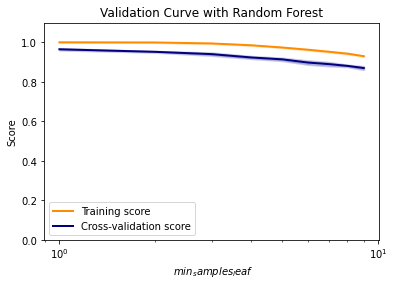

In [114]:
plt.title("Validation Curve with Random Forest")
plt.xlabel(r"$\ min_samples_leaf$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(min_samples_leaf_range, rfc_min_samples_leaf_train_score_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(min_samples_leaf_range, rfc_min_samples_leaf_train_score_mean - rfc_min_samples_leaf_train_score_std,
                 rfc_min_samples_leaf_train_score_mean + rfc_min_samples_leaf_train_score_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(min_samples_leaf_range, rfc_min_samples_leaf_test_score_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(min_samples_leaf_range, rfc_min_samples_leaf_test_score_mean - rfc_min_samples_leaf_test_score_std,
                 rfc_min_samples_leaf_test_score_mean + rfc_min_samples_leaf_test_score_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

###### On affine l'intervalle tel que:

In [115]:
n_estimators_range = np.arange(1, 3, 1)

##### On cherche maintenant les hyperparamètres idéaux

In [123]:
param_distributions = {'criterion': criterion_range,
                       'max_depth': max_depth_range,
                       'min_samples_split': min_samples_split_range,
                       'max_features': max_features_range}

search = RandomizedSearchCV(estimator=RandomForestClassifier(),
                            n_iter=5,
                            param_distributions=param_distributions,
                            random_state=0)
search.fit(x_train, y_train)

C:\Users\quent\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\quent\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\quent\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\quent\anaconda3\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\quent\anaconda3\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\quent\anaconda3\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96]),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_split': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9]},
                   random_state=0)

In [124]:
search.best_params_, search.score(x_train, y_train)

({'min_samples_split': 8,
  'max_features': 'auto',
  'max_depth': 41,
  'criterion': 'entropy'},
 0.9996164663768857)

In [125]:
if (search.score(x_train, y_train) > accuracy_rfc_model):
    rfc_model = search

In [ ]:
filename = 'finalized_model.sav'
pickle.dump(knn_model, open(filename, 'wb'))